In [1]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
palette = 'husl'
sns.set_palette(palette)
from scipy.optimize import minimize
import logging

!pip install keras-tuner -q
import keras_tuner

import pandas_datareader.data as web # for FRED data
from datetime import datetime, date
import holidays
from scipy.optimize import Bounds, LinearConstraint
import warnings


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Bidirectional, BatchNormalization, Concatenate, Dropout, Reshape


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
!pip install lime
from lime import explanation
from lime import lime_base
from lime.lime_tabular import RecurrentTabularExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3d3429398992660dd06d964b2e80a1551d451f6168f6954c212faad18a53e61f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:
from google.colab import drive
drive.mount('/content/drive')
CACHE_PATH='./drive/MyDrive/checkpoints'

Mounted at /content/drive


In [5]:
# Set constants
TIME_STEP=50
START_DATE = '2005-12-31'
END_DATE = '2023-12-29'
TICKERS = ['DBC','AGG', 'VTI', 'VNQ', 'FXE'] # Add more assets, model 1 talks about stock selection
FRED_TICKERS_DICT = {
    'DCOILWTICO': 'wti',  # https://fred.stlouisfed.org/series/DCOILWTICO/
    'T5YIE': 'inflation5y',  # https://fred.stlouisfed.org/series/T5YIE
    'DGS10': 'treasury10y',  # https://fred.stlouisfed.org/series/DGS10
    'VIXCLS': 'vix',  # https://fred.stlouisfed.org/series/VIXCLS/
    'BAMLH0A0HYM2': 'credit_spreads',  # https://fred.stlouisfed.org/series/BAMLH0A0HYM2/
    'FEDFUNDS': 'fedfunds' # Monthly, will be filled forward https://fred.stlouisfed.org/series/fedfunds
}
TRAIN_TEST_SPLIT = 0.80

In [6]:
# Data range is used as an example hear  to show how we extract data
history = {ticker: yf.Ticker(ticker).history(start=START_DATE, end=END_DATE) for ticker in TICKERS}

## Preprocessing

Before doing anything else, we made sure to preserve the chronological sequence of the data by dividing it into a 75%-25% split. Furthermore, we split the  training data into 80%-20%, with the former for training & the latter 20% (representing 15% of the total data) utilized for validation during hyperparameter tuning

### Preprocessing code

In [7]:
class Preprocessing:
    def __init__(self, tickers: list = TICKERS, time_step: int = 30,
                 start_date: str = START_DATE, end_date: str = END_DATE,
                 train_test_split: float = 0.8,
                 return_horizon: int = 1,  # 1-day returns
                 asset_features: list = ['Close', 'Volume'],
                 features_in_returns: list = ['wti'] + [t+'_Close' for t in TICKERS] + [t+'_Volume' for t in TICKERS],
                 features_in_level_diffs: list = ['inflation5y', 'treasury10y', 'vix', 'credit_spreads'],
                 target_col: str = 'Close',
                 add_external_data: bool = True,
                 keep_weekly_only: bool = False,
                 explanatory_tickers: dict = FRED_TICKERS_DICT):
        self.tickers = tickers
        self.time_step = time_step
        self.start_date = start_date
        self.end_date = end_date
        self.train_test_split = train_test_split
        self.add_external_data = add_external_data
        self.keep_weekly_only = keep_weekly_only
        self.raw_history = {}
        self.return_horizon = return_horizon
        self.asset_features = asset_features
        self.features_in_returns = features_in_returns
        self.features_in_level_diffs = features_in_level_diffs
        self.target_col = target_col
        self.explanatory_tickers = explanatory_tickers

        self.history_train_df = pd.DataFrame()
        self.history_test_df = pd.DataFrame()
        self.risk_free_train = pd.DataFrame()
        self.risk_free_test = pd.DataFrame()
        self.x_train = np.array([])
        self.y_train = np.array([])
        self.x_scaler_train = None
        self.y_scaler_train = None
        self.x_test = np.array([])
        self.y_test = np.array([])
        self.x_scaler_test = None
        self.y_scaler_test = None

    def _import_data(self):
        logging.info('Importing data from Yahoo...')
        self.raw_history = {ticker: yf.Ticker(ticker).history(start=self.start_date, end=self.end_date)
                            for ticker in self.tickers}

    def import_fred_data(self):
        """
        Import economic data from FRED.
        Remove weekends and holidays. Forward fill NAs, useful for instance
        with FedFunds available monthly
        """
        start = datetime.strptime(START_DATE, '%Y-%m-%d')
        end = datetime.strptime(END_DATE, '%Y-%m-%d')
        external_data = web.DataReader(list(self.explanatory_tickers.keys()), "fred", start, end)
        external_data = external_data.rename(columns=self.explanatory_tickers)

        us_holidays = holidays.UnitedStates()
        holiday_filter = [dt not in us_holidays for dt in external_data.index.date]
        external_data = external_data[(external_data.index.weekday < 5)&(holiday_filter)]
        external_data = external_data.fillna(method='ffill').dropna()

        for col in external_data.columns.values:
            if any(x in col for x in self.features_in_returns):
                external_data[col] = np.log(external_data[col]) - np.log(external_data[col].shift(
                    self.return_horizon))
            if any(x in col for x in self.features_in_level_diffs):
                external_data[col] = external_data[col] - external_data[col].shift(
                    self.return_horizon)

        return external_data

    def _preprocess_data(self, history_data, tickers):
        """
        Place all the input data into one data frame. Add log returns
        where the field should be defined in returns. Fill in nulls.
        """
        feat_df = []
        for ticker in tickers:
            ticker_df = history_data[ticker][self.asset_features].copy()
            names_dict = dict(zip(self.asset_features, [f'{ticker}_{ft}' for ft in self.asset_features]))
            ticker_df.rename(columns=names_dict, inplace=True)
            feat_df.append(ticker_df)

        feat_df = pd.concat(feat_df, axis=1)
        feat_df = feat_df.fillna(method='ffill')

        feat_df_incl_ret = feat_df.copy()

        for col in feat_df.columns.values:
            if any(x in col for x in self.features_in_returns) and any(x not in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = np.log(feat_df_incl_ret[col]) - np.log(feat_df_incl_ret[col].shift(
                    self.return_horizon))
            elif any(x in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = feat_df_incl_ret[col] - feat_df_incl_ret[col].shift(
                    self.return_horizon)

        feat_df_incl_ret.dropna(inplace=True)

        feat_df_incl_ret.reset_index(drop=False, inplace=True)
        feat_df_incl_ret['Date'] = pd.to_datetime(feat_df_incl_ret['Date']).dt.date
        feat_df_incl_ret.set_index('Date', inplace=True)

        return feat_df_incl_ret

    def create_x_y_sequences(self, data_df, lookback):
        """
        Creates input sequences for a time series data with a specified lookback window.
        Assumes that y (target) is one of the columns in data_df.
        Transform the data into sequence of lookback length to predict one step forward (y).
        """
        sequences = []
        targets = []
        target_cols = [col for col in data_df.columns.values if self.target_col in col]

        y_data = data_df[target_cols].values
        x_data = data_df.values

        x_scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaler = MinMaxScaler(feature_range=(0, 1))

        x_data = x_scaler.fit_transform(x_data)
        y_data = y_scaler.fit_transform(y_data)

        for i in range(len(data_df) - lookback):
            x_sequence = x_data[i: i + lookback]
            y_target = y_data[i + lookback]
            sequences.append(x_sequence)
            targets.append(y_target)

        return np.array(sequences), np.array(targets), x_scaler, y_scaler

    def run(self):
        """
        Source data if it has not been sourced.
        Split the data into train and test, and standardise.
        Clean and prepare data in the sequence format needed for modelling.
        """
        history_train = {}
        history_test = {}

        if len(self.raw_history) == 0:
            self._import_data()

        # Train Test split
        for ticker, data in self.raw_history.items():
            train_size = int(len(data) * self.train_test_split)
            history_train[ticker], history_test[ticker] = data[:train_size], data[train_size:]

        history_train_clean = self._preprocess_data(history_train, self.tickers)
        history_test_clean = self._preprocess_data(history_test, self.tickers)

        self.history_train_df = history_train_clean
        self.history_test_df = history_test_clean

        # Join with FRED macro data
        if self.add_external_data:
            fred_df = self.import_fred_data()
            self.history_test_df = self.history_test_df.join(fred_df, how='inner').fillna(method='ffill').dropna()
            self.history_train_df = self.history_train_df.join(fred_df, how='inner').fillna(method='ffill').dropna()

            self.risk_free_train = pd.DataFrame(self.history_train_df['fedfunds'][self.time_step:])
            self.risk_free_test = pd.DataFrame(self.history_test_df['fedfunds'][self.time_step:])

        if self.keep_weekly_only:
            self.history_test_df = self.history_test_df[(self.history_test_df.index.weekday == 4)]
            self.history_train_df = self.history_train_df[(self.history_train_df.index.weekday == 4)]

            if self.add_external_data:
              self.risk_free_train = self.risk_free_train[(self.risk_free_train.index.weekday == 4)]
              self.risk_free_test = self.risk_free_test[(self.risk_free_test.index.weekday == 4)]
        # Prepare modelling sequences of train and test
        self.x_train, self.y_train, self.x_scaler_train, self.y_scaler_train = self.create_x_y_sequences(
            self.history_train_df, self.time_step)
        self.x_test, self.y_test, self.x_scaler_test, self.y_scaler_test = self.create_x_y_sequences(
            self.history_test_df, self.time_step)

        data_struct = {
            'x_train': self.x_train,
            'y_train': self.y_train,
            'x_test': self.x_test,
            'y_test': self.y_test,

            'x_scaler_train': self.x_scaler_train,
            'y_scaler_train': self.y_scaler_train,
            'x_scaler_test': self.x_scaler_test,
            'y_scaler_test': self.y_scaler_test
        }
        return data_struct


### Preprocessing - run

In [8]:
pp = Preprocessing(
    time_step=TIME_STEP,
    tickers=TICKERS,
    add_external_data=True,
    keep_weekly_only=True,
    explanatory_tickers=FRED_TICKERS_DICT,
    asset_features=['Close', 'Volume'],
    features_in_returns=['wti'] + [t+'_Close' for t in TICKERS] + [t+'_Volume' for t in TICKERS],
    features_in_level_diffs=['inflation5y', 'treasury10y', 'vix', 'credit_spreads'], #'AGG_Close'
    return_horizon=5)

data = pp.run()

X_train = data['x_train']
Y_train = data['y_train']
X_test = data['x_test']
Y_test = data['y_test']

X_scaler_train = data['x_scaler_train']
y_scaler_train = data['y_scaler_train']
X_scaler_test = data['x_scaler_test']
y_scaler_test = data['y_scaler_test']

history_train_clean = pp.history_train_df
history_train_clean.shape


# Extract these indices, will be needed for plotting
test_date_index = pp.history_test_df[TIME_STEP:].index
train_date_index = pp.history_train_df[TIME_STEP:].index

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


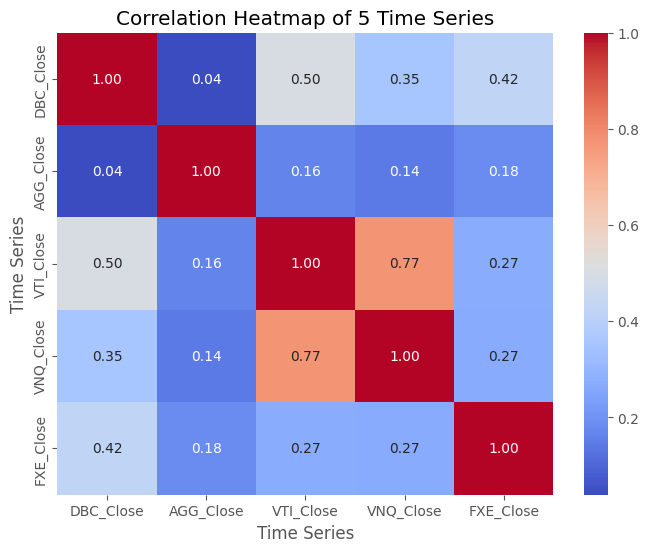

In [9]:
# Calculate the correlation matrix - not very correlated. That's why multihead approach could help
target_cols = [col for col in history_train_clean.columns.values if 'Close' in col]

correlation_matrix = np.corrcoef(history_train_clean[target_cols], rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=target_cols, yticklabels=target_cols)
plt.title('Correlation Heatmap of 5 Time Series')
plt.xlabel('Time Series')
plt.ylabel('Time Series')
plt.show()

## Model Selection
The models implemented in this notebook are CNN-BiLSTM architectures as described in Chaweewanchon, A., & Chaysiri, R. (2022). Inorder to further improve the prediction performance of the model, The existing sequential architecture was modified to A Double-Channel Hybrid Deep Neural Network Based on CNN and BiLSTM as described in Zhao C, Huang X, Li Y, Yousaf Iqbal M.






Markowitz Mean-Variance Portfolio Optimization with Predictive Stock Selection Using Machine Learning. International Journal of Financial Studies, 10(3), 64. https://doi.org/10.3390/ijfs10030064

Zhao C, Huang X, Li Y, Yousaf Iqbal M. A Double-Channel Hybrid Deep Neural Network Based on CNN and BiLSTM for Remaining Useful Life Prediction. Sensors (Basel). 2020 Dec 11;20(24):7109. doi: 10.3390/s20247109. PMID: 33322457; PMCID: PMC7764061.


was later modified

### Helper Functions

In [10]:
def plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy'):
  '''
  Plot training and validation loss
  '''
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.plot(train_fitted.history[metric1],'-o', label=f'Training {metric1}'.format())
  ax1.plot(train_fitted.history[f'val_{metric1}'.format()],'-o', label=f'Validation {metric1}'.format())
  ax1.set_title(f'Training and validation {metric1}'.format())
  ax1.set_ylabel(f'{metric1}'.format())
  ax1.set_xlabel('epoch')
  ax1.legend(loc='upper right')

  ax2.plot(train_fitted.history[metric2],'-o', label=f'Training {metric2}'.format())
  ax2.plot(train_fitted.history[f'val_{metric2}'.format()],'-o', label=f'Validation {metric2}'.format())
  ax2.set_title(f'Training and validation {metric2}'.format())
  ax2.set_ylabel(f'{metric2}'.format())
  ax2.set_xlabel('epoch')
  ax2.legend(loc='lower right')
  f.suptitle(plot_title)


def plot_returns(Y_true, Y_hat, time_axis=None):
  '''
  Plot predicted vs actual time series.
  If time axis is provided, set it as an axis rather than having integers as tick marks
  '''
  num_variables = len(TICKERS)
  fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, 10))

  # Plot predicted and actual values for each variable
  for i in range(num_variables):
      ax = axes[i]
      if time_axis is not None:
        ax.plot(time_axis, Y_true[:, i], label='Actual') #, color='blue'
        ax.plot(time_axis, Y_hat[:, i], label='Predicted') #, color='red'
      else:
        ax.plot(Y_true[:, i], label='Actual') #, color='blue'
        ax.plot(Y_hat[:, i], label='Predicted') #, color='red'
      ax.set_title(TICKERS[i])
      ax.legend()

  # Set common labels and layout
  plt.xlabel('Time')
  plt.tight_layout()
  plt.show()

### Markowitz Optimisation - Code

In [11]:
def markowitz_portfolio(returns, cov_matrix, risk_free_rate, initial_weights=None,
                        diversification_penalty_coeff=0.1, deviation_penalty_coeff=0.1,
                        time_window=1):
    """
  Get portfolio weights based on Markowitz model across time. Starts from equal weights.
  Then use previous period weights as a reference point. Time window is the lenght
  of historical data to take into account. It needs to be greater or equal to 1
  so that there are at least 2 observations for covariance
  (at least one history + prediction)
    """
    num_assets = len(returns)
    if initial_weights is None:
        initial_weights = np.array([1 / num_assets] * num_assets)

    # Define constraints (sum of weights equals 1). Commented out set-up is for SLSQP optimizer
    #constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    constraints = LinearConstraint(np.repeat(1, num_assets), [1], [1])
    # Define bounds (weights between 0 and 1)
    #bounds = tuple((0, 1) for asset in range(num_assets))
    bounds = Bounds(np.repeat(0, num_assets), np.repeat(1, num_assets))

    # Define the objective function to minimize
    def negative_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, returns)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
        diversification_penalty = np.sum(weights**2)
        deviation_penalty = np.sum((weights - initial_weights)**2)

        return (-sharpe_ratio +
                diversification_penalty_coeff * diversification_penalty +
                deviation_penalty_coeff * deviation_penalty)

    # Initialize optimization, need SLSQP or trust-constr given constraints.
    # Trust-constr is slower but results in a better convergence
    result = minimize(negative_sharpe_ratio, initial_weights, method='trust-constr', bounds=bounds,
                      constraints=constraints)

    # Try again with equal weights if optimization fails
    if not result.success:
      result = minimize(negative_sharpe_ratio, np.array([1 / num_assets] * num_assets),
                        method='SLSQP', bounds=bounds,
                        constraints=constraints)

    if not result.success:
        raise ValueError("Optimization failed: " + result.message)

    return result.x

def markowitz_weights(Y_realised, Y_predictions, risk_free_rates=0.02, time_window=1,
                      average_return_with_history=True, # take an average over prediction plus history in Markowitz
                      diversification_penalty_coeff=0.1, deviation_penalty_coeff=0.1):
    """
    Get portfolio weights based on Markowitz model across time. Starts from equal weights.
    Time window is the length of historical data to take into account. It needs to
    be greater or equal to 1 so that there are at least 2 observations for covariance
    (at least one history + prediction)
    """
    starting_weights = np.array([1.0 / len(TICKERS)] * len(TICKERS))
    all_weights = None
    for i in range(time_window, len(Y_realised)):
        ret_sequence = np.vstack([Y_realised[i - time_window : i], Y_predictions[i]])
        ret_sequence = np.exp(ret_sequence)-1 # Transform log returns to returns
        if average_return_with_history:
          mean_returns = np.mean(ret_sequence, axis=0)
        else:
          mean_returns = np.exp(Y_predictions[i])-1
        cov_matrix = np.cov(ret_sequence, rowvar=False)

        # Time-varying RF rate if provided, otherwise constant
        risk_free_rate = risk_free_rates[i] if len(risk_free_rates) > 1 else risk_free_rates

        weights = markowitz_portfolio(mean_returns, cov_matrix, risk_free_rate,
                                      initial_weights=starting_weights,
                                      diversification_penalty_coeff=diversification_penalty_coeff,
                                      deviation_penalty_coeff=deviation_penalty_coeff,
                                      time_window=time_window)
        all_weights = np.vstack([all_weights, weights]) if all_weights is not None else np.array([weights])

        # Use previous weights as a starting point for next optimization
        starting_weights = weights

    return all_weights


def plot_portfolio_weights(weights):
  """
  Plot portfolio weights. USes constants defined top of this notebook as labels
  """
  fig, ax = plt.subplots(figsize=(10, 6))
  bottom = np.zeros(weights.shape[0])

  for i in range(weights.shape[1]):
      ax.bar(range(weights.shape[0]), weights[:, i], label=TICKERS[i], bottom=bottom)
      bottom += weights[:, i]

  ax.set_xlabel('Time')
  ax.set_ylabel('Weights')
  ax.set_title('Portfolio Weights Over Time')
  ax.legend()
  ax.grid(True)
  plt.show()


def calculate_and_plot_returns(returns_data, weights1, weights2,
                               label1='Model1 Strategy', label2='Equal Weights',
                               plot_title='Test returns', time_axis=None,
                               return_df=False):
  """
  Calculate within period portfolio log returns and aggregated returns.
  Plot only, or plot and output a dataframe with results.
  Assumes we want our strategy and a benchmark strategy.
  Time axis is optional.
  """
  portfolio_log_returns = (weights1 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)
  portfolio_log_returns2 = (weights2 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)

  # Cumulative log returns
  cumulative_portfolio_log_return = np.cumsum(portfolio_log_returns)
  cumulative_portfolio_log_return2 = np.cumsum(portfolio_log_returns2)

  # Normal returns?
  cumulative_portfolio_return = np.exp(cumulative_portfolio_log_return) - 1
  cumulative_portfolio_return2 = np.exp(cumulative_portfolio_log_return2) - 1

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.plot(cumulative_portfolio_log_return, label=label1)
  ax1.plot(cumulative_portfolio_log_return2, label=label2)
  ax1.set_title('Cumulative log returns')
  ax1.set_ylabel('Cumulative log returns')
  ax1.set_xlabel('Time')
  ax1.legend(loc='upper right')

  ax2.plot(cumulative_portfolio_return, label=label1)
  ax2.plot(cumulative_portfolio_return2, label=label2)
  ax2.set_title('Cumulative returns')
  ax2.set_ylabel('Cumulative returns')
  ax2.set_xlabel('Time')
  ax2.legend(loc='upper right')
  f.suptitle(plot_title)

  output = {
      label1 + ' Log Return': portfolio_log_returns,
      label2 + ' Log Return': portfolio_log_returns2,
      label1 + ' Cumulative Log Return': cumulative_portfolio_log_return,
      label2 + ' Cumulative Log Return': cumulative_portfolio_log_return2,
      label1 + ' Cumulative Return': cumulative_portfolio_return,
      label2 + ' Cumulative Return': cumulative_portfolio_return2,
    }
  if time_axis is not None:
    output['Date'] = time_axis[MARKOWITZ_TIME_WINDOW:]

  if return_df:
    return pd.DataFrame(output)
  else:
    return

### CNN-BILSTM
Traditional CNN-BILSTM Sequential Architecture described in the paper.

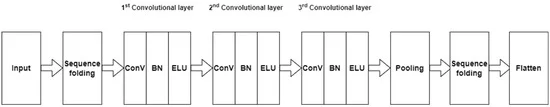



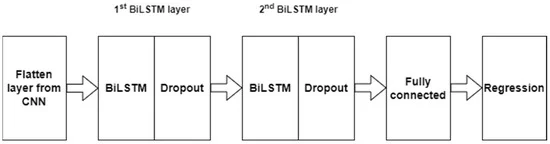

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 100)           4900      
                                                                 
 batch_normalization (Batch  (None, 50, 100)           400       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 100)           50100     
                                                                 
 batch_normalization_1 (Bat  (None, 50, 100)           400       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 50)            35050     
                                                                 
 batch_normalization_2 (Bat  (None, 50, 50)            2

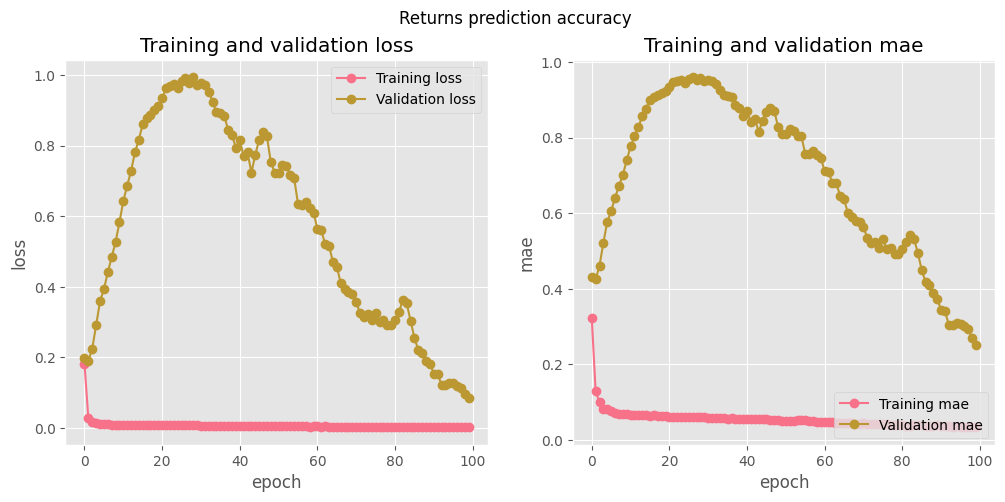

In [12]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Bidirectional, LSTM, Dense, Dropout

# Define the model
model = Sequential()

# CNN feature extraction
model.add(Conv1D(filters=100, kernel_size=3, strides=1, activation='elu', input_shape=(TIME_STEP, X_train.shape[2]), padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(filters=100, kernel_size=5, strides=1, activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(filters=50, kernel_size=7, strides=1, activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Flatten the data
#model.add(Flatten()) #issue with flatten, maybe the architecture was describing Sequence unfolding layer, which is happes by default in tf


# BiLSTM for price prediction
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dense(256, activation='tanh'))  # Second BiLSTM layer
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=16)))
model.add(Dense(5))  # Output layer

model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics=['mae'])

train_fitted = model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_split=0.2, verbose=0) #, callbacks=[callback]

plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy')


In [13]:
# Evaluation of the model on test data
scores = model.evaluate(X_test, Y_test, verbose=0)
scores
print(f"MSE: {scores[0]}" )

# Predict train
train_predictions = model.predict(X_train)

train_predictions_scaled = y_scaler_train.inverse_transform(train_predictions)
Y_train_scaled = y_scaler_train.inverse_transform(Y_train)

# Predict test
test_predictions = model.predict(X_test)

test_predictions_scaled = y_scaler_test.inverse_transform(test_predictions)
Y_test_scaled = y_scaler_test.inverse_transform(Y_test)

MSE: 0.04648132622241974
4/4 [==============================] - 0s 14ms/step


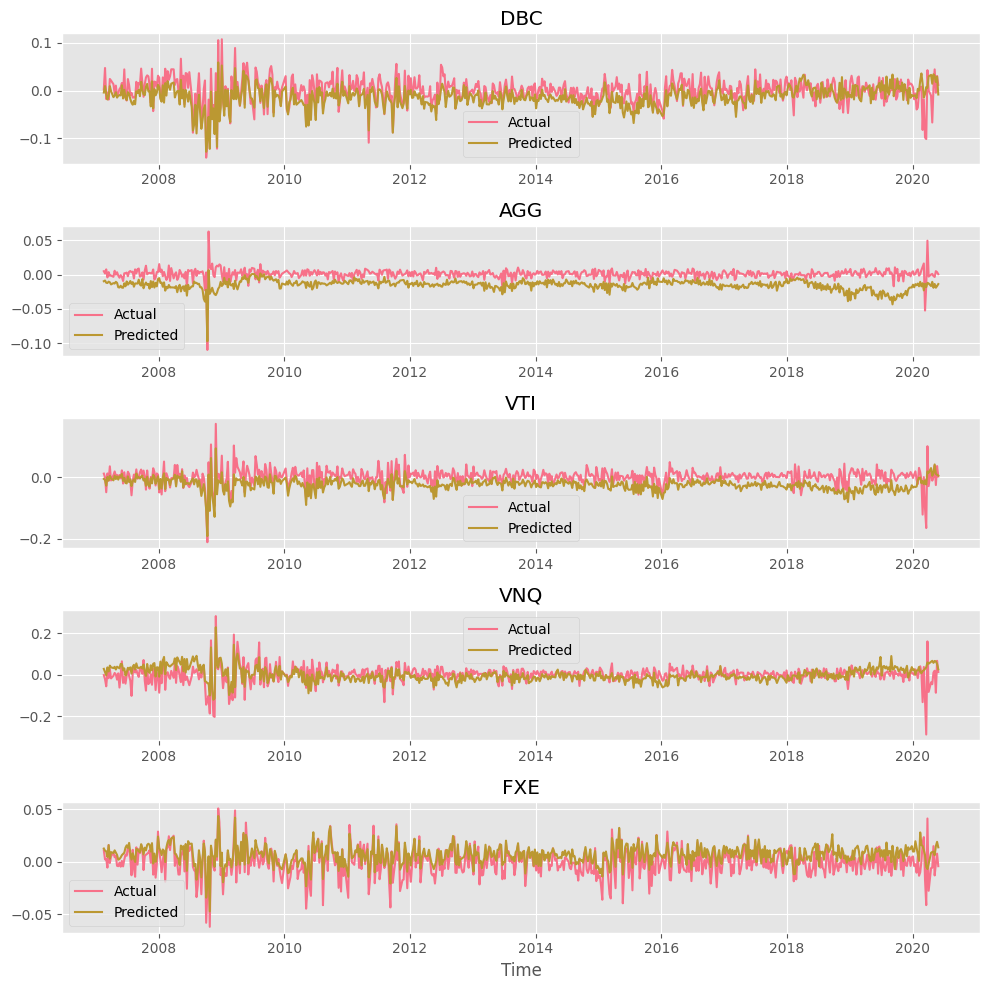

In [ ]:
plot_returns(Y_train_scaled, train_predictions_scaled,time_axis=train_date_index)

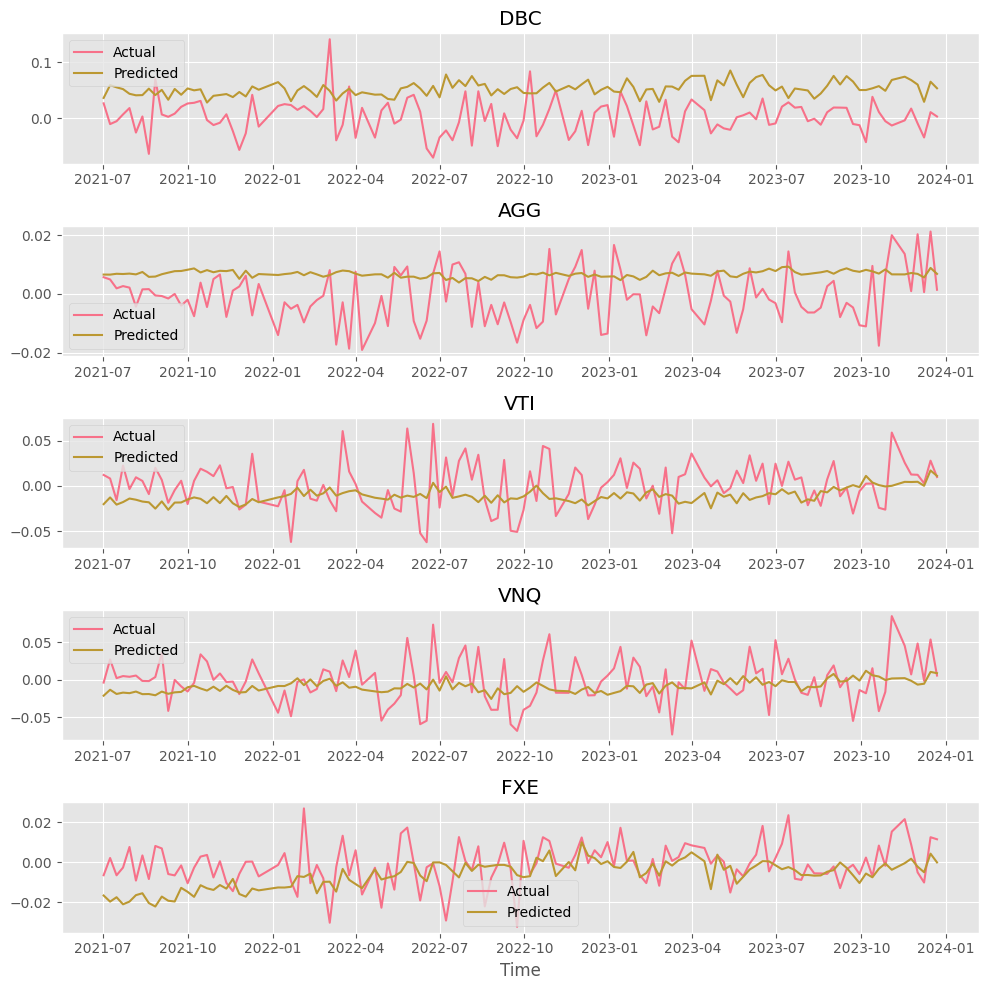

In [ ]:
plot_returns(Y_test_scaled, test_predictions_scaled, time_axis=test_date_index)

#### Markowitz Portfolio

In [14]:
# time window to consider in cov matrix, and to calculate an average for E(R)
# if average_return_with_history is set to true
MARKOWITZ_TIME_WINDOW = 5

# Create equal weights portfolio to serve as a performance benchmark (a naive model)
equal_weights_test = np.array([np.repeat(1/len(TICKERS), len(TICKERS)) for _ in
                               range(Y_test_scaled[MARKOWITZ_TIME_WINDOW:].shape[0])])

equal_weights_train = np.array([np.repeat(1/len(TICKERS), len(TICKERS)) for _ in
                                range(Y_train_scaled[MARKOWITZ_TIME_WINDOW:].shape[0])])

# Divide by 52 to make the annual RF rate weekly
risk_free_train = pp.risk_free_train['fedfunds']/(100*52)
risk_free_test = pp.risk_free_test['fedfunds']/(100*52)

# Silence (BUT TO DO - CHECK AND JUSTIFY) - running many optimizations and some of them show this warning
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

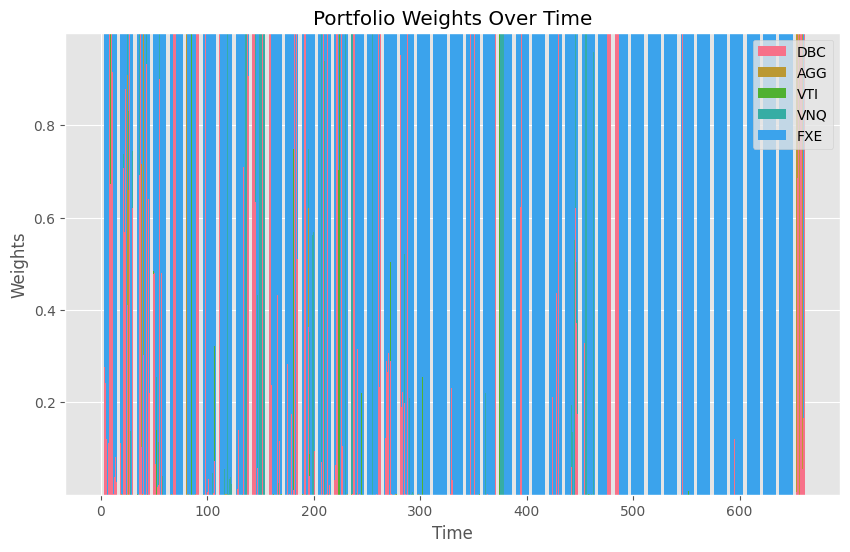

In [15]:
train_weights = markowitz_weights(Y_train_scaled, train_predictions_scaled,
                                  average_return_with_history=False,
                                  risk_free_rates=risk_free_train, # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(train_weights)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

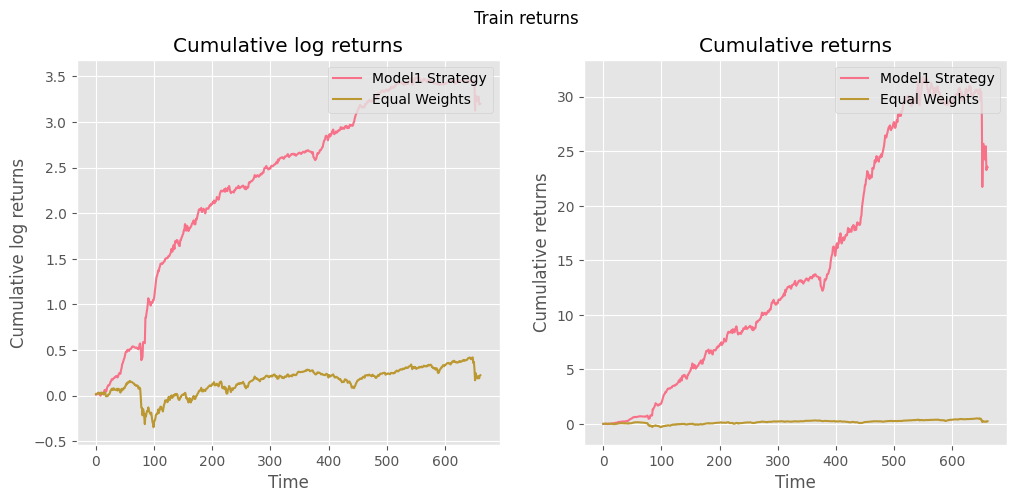

In [ ]:
from google.colab import files
train_ret_df = calculate_and_plot_returns(Y_train_scaled, train_weights, equal_weights_train, plot_title='Train returns', time_axis=train_date_index, return_df=True)



train_ret_df.to_csv('Model2_Train_org.csv')
files.download('Model2_Train_org.csv')

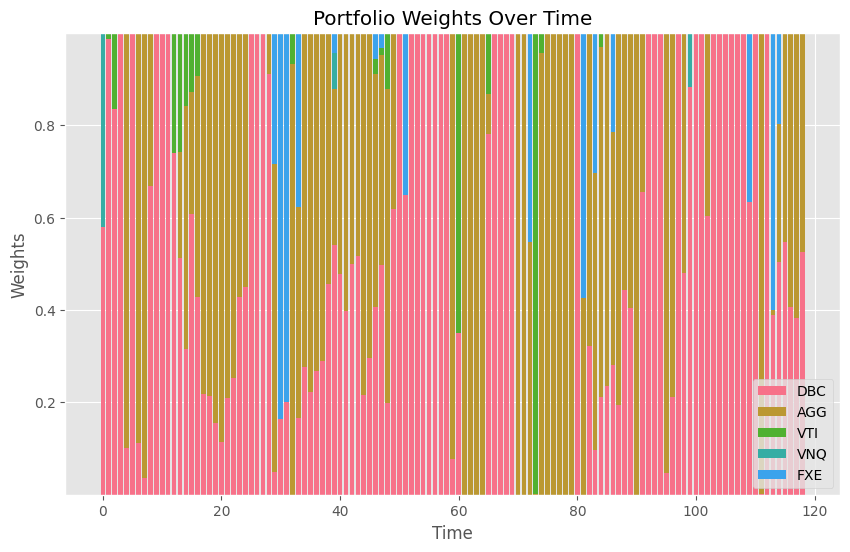

In [16]:
MARKOWITZ_TIME_WINDOW = 5
test_weights = markowitz_weights(Y_test_scaled, test_predictions_scaled,
                                 average_return_with_history=False,
                                  risk_free_rates=risk_free_test, # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(test_weights)

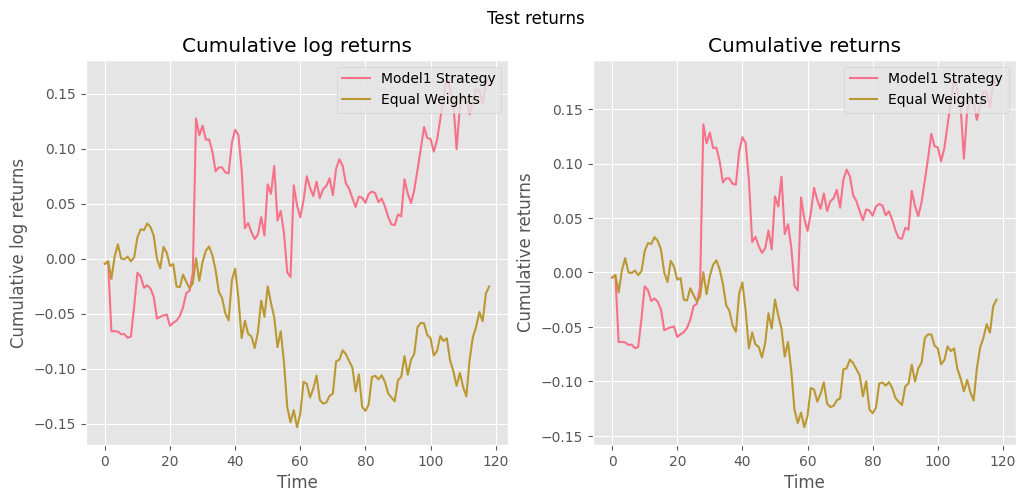

In [ ]:
test_ret_df = calculate_and_plot_returns(Y_test_scaled, test_weights, equal_weights_test,
                                          plot_title='Test returns',
                                          time_axis=test_date_index, return_df=True)
#test_ret_df.to_csv('Model2_Test_org.csv')
#files.download('Model2_Test_org.csv')

### Lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=31ca38096a8ece135497eba776a36a7494e08f146e0b1e15fc90bfffe99a306b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


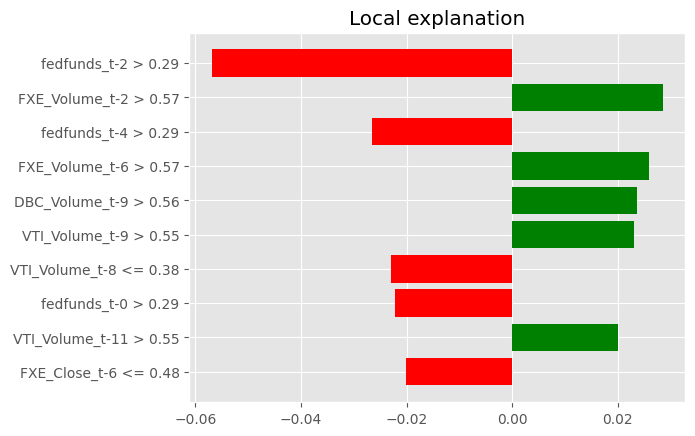

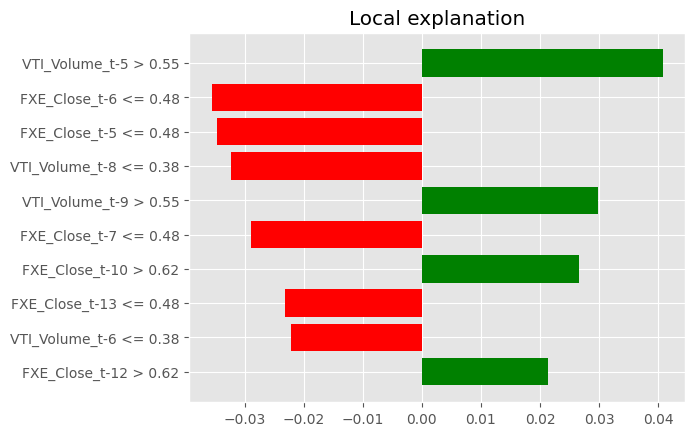

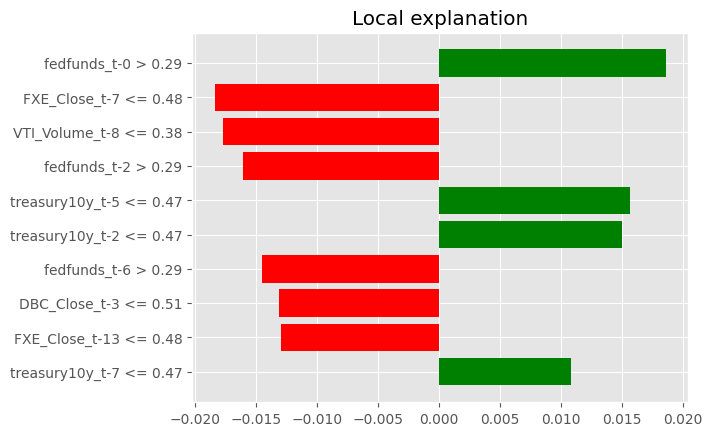

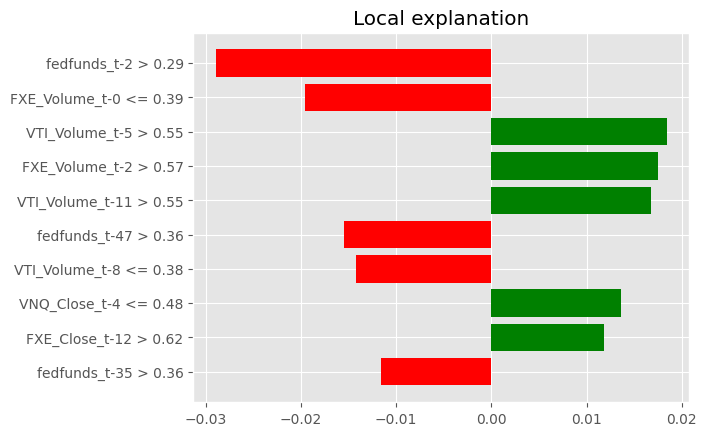

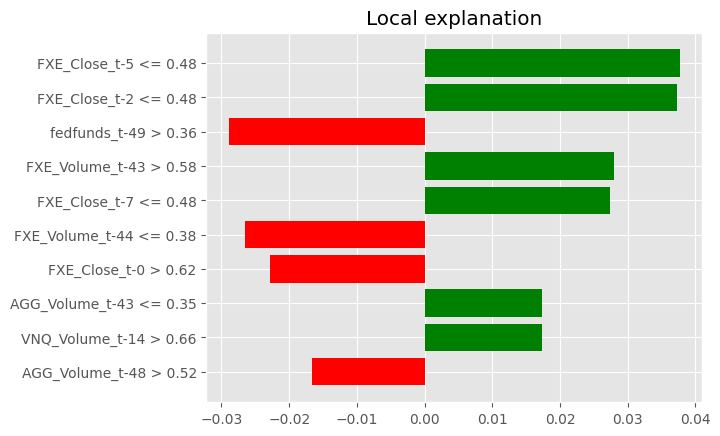

In [20]:
!pip install lime
from lime import explanation
from lime import lime_base
from lime.lime_tabular import RecurrentTabularExplainer

# this is used for probabilities, but our data is normalised, so we use this to explain
for i in range(5):
  idx = 81 # explained instance
  num_features = 5 # how many feature contained in explanation
  num_slices = 24 # split time series
  series = X_train[idx, :]
  explainer = RecurrentTabularExplainer(X_train, mode='regression', feature_names=pp.history_train_df.columns)
  exp = explainer.explain_instance(series, lambda x: model(x).numpy().reshape(-1,5)[:,i])
  exp.as_pyplot_figure()
  plt.show()

### CNN-BILSTM-Modified

We can see that the model discussed in the paper doesnt seem to pick the strokes and curvature to the actual data. The folowing model is the modified version of previous model incorporating a double channel CNN-BILSTM architecture with an aim to make model to start picking up the curvature.

In [21]:
# Define the input shape
input_shape = (TIME_STEP, X_train.shape[2])

# Input layer
input_layer = Input(shape=input_shape)

# CNN Branch
cnn = Conv1D(filters=128, kernel_size=3, strides=1, activation='elu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=5, strides=1, activation='elu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
#cnn = MaxPooling1D(pool_size=2)(cnn)
"""
cnn = Conv1D(filters=12, kernel_size=7, strides=1, activation='elu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
#cnn = MaxPooling1D(pool_size=2)(cnn) #Gave better results without MaxPooling
"""
cnn = Flatten()(cnn)

# LSTM Branch with additional layers and dropout for regularization
lstm = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
lstm = Dropout(0.3)(lstm)  # Dropout for regularization
"""
lstm = Bidirectional(LSTM(32, return_sequences=True))(lstm)
lstm = Dropout(0.3)(lstm)  # Additional dropout layer for regularization
"""
lstm = Bidirectional(LSTM(16, return_sequences=False))(lstm)  # Last LSTM layer does not return sequences

# Concatenate CNN and LSTM outputs
concatenated = Concatenate()([cnn, lstm])

# Reshape for BiLSTM input
reshaped = Reshape((1, -1))(concatenated)

# BiLSTM Layer
lstm = Bidirectional(LSTM(128))(reshaped)
#lstm = Dense(256, activation='tanh')(lstm)
#lstm = Dropout(0.2)(lstm)
#lstm = Bidirectional(LSTM(16))(lstm)


# Output Layer
output = Dense(5)(lstm)

# Create the model
model = Model(inputs=input_layer, outputs=output)



model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 16)]             0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 50, 128)              6272      ['input_1[0][0]']             
                                                                                                  
 batch_normalization_3 (Bat  (None, 50, 128)              512       ['conv1d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 25, 128)              0         ['batch_normalization_3[0]

In [22]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics=['mae'])

In [ ]:
# Fit
#callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, start_from_epoch=100)
train_fitted = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2) #, callbacks=[callback]

Epoch 1/100
17/17 - 16s - loss: 0.0677 - mae: 0.1964 - val_loss: 0.1877 - val_mae: 0.4095 - 16s/epoch - 947ms/step
Epoch 2/100
17/17 - 0s - loss: 0.0142 - mae: 0.0924 - val_loss: 0.1374 - val_mae: 0.3476 - 492ms/epoch - 29ms/step
Epoch 3/100
17/17 - 1s - loss: 0.0064 - mae: 0.0607 - val_loss: 0.1159 - val_mae: 0.3170 - 552ms/epoch - 32ms/step
Epoch 4/100
17/17 - 1s - loss: 0.0043 - mae: 0.0505 - val_loss: 0.1333 - val_mae: 0.3460 - 527ms/epoch - 31ms/step
Epoch 5/100
17/17 - 1s - loss: 0.0030 - mae: 0.0413 - val_loss: 0.1365 - val_mae: 0.3492 - 520ms/epoch - 31ms/step
Epoch 6/100
17/17 - 1s - loss: 0.0023 - mae: 0.0370 - val_loss: 0.1411 - val_mae: 0.3562 - 558ms/epoch - 33ms/step
Epoch 7/100
17/17 - 1s - loss: 0.0019 - mae: 0.0332 - val_loss: 0.1519 - val_mae: 0.3705 - 504ms/epoch - 30ms/step
Epoch 8/100
17/17 - 0s - loss: 0.0015 - mae: 0.0295 - val_loss: 0.1374 - val_mae: 0.3525 - 349ms/epoch - 21ms/step
Epoch 9/100
17/17 - 0s - loss: 0.0012 - mae: 0.0257 - val_loss: 0.1338 - val_mae

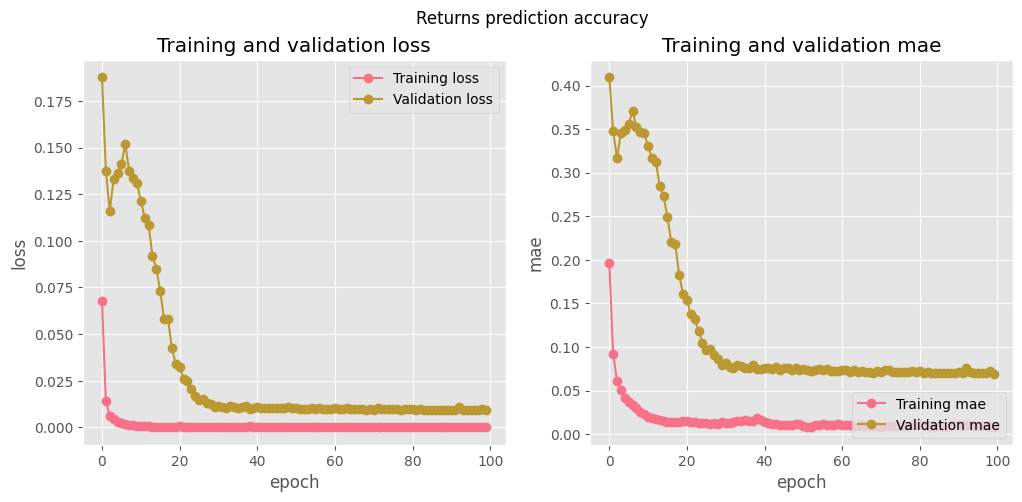

In [ ]:
plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy')

In [ ]:
keras.saving.save_model(model, CACHE_PATH + '/st456_portfolio_project_model_paper1', overwrite=True)
model = keras.saving.load_model(CACHE_PATH + '/st456_portfolio_project_model_paper1')

In [23]:
model = keras.saving.load_model(CACHE_PATH + '/st456_portfolio_project_model_paper1')

In [24]:
# Evaluation of the model on test data
scores = model.evaluate(X_test, Y_test, verbose=0)
scores
print(f"MSE: {scores[0]}" )

# Predict train
train_predictions = model.predict(X_train)

train_predictions_scaled = y_scaler_train.inverse_transform(train_predictions)
Y_train_scaled = y_scaler_train.inverse_transform(Y_train)

# Predict test
test_predictions = model.predict(X_test)

test_predictions_scaled = y_scaler_test.inverse_transform(test_predictions)
Y_test_scaled = y_scaler_test.inverse_transform(Y_test)

MSE: 0.057872358709573746
4/4 [==============================] - 0s 9ms/step


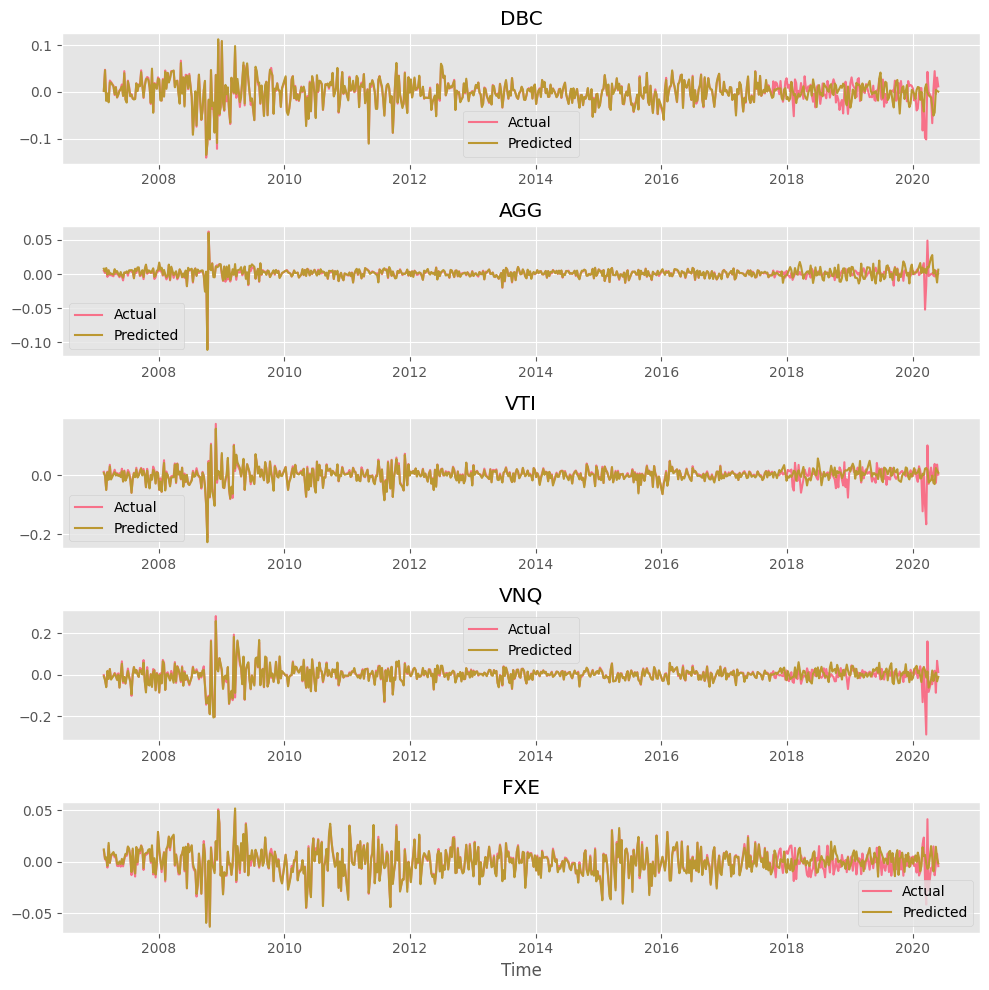

In [ ]:
plot_returns(Y_train_scaled, train_predictions_scaled, time_axis=train_date_index)

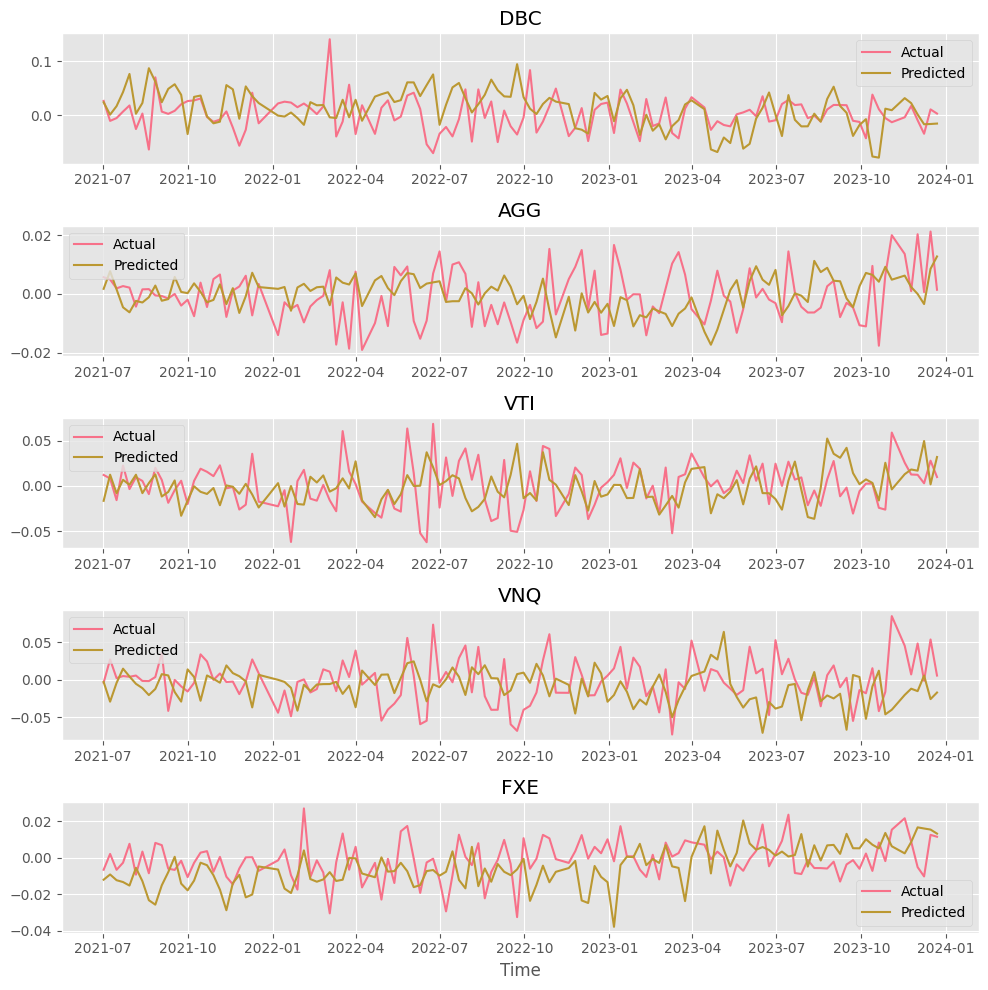

In [ ]:
plot_returns(Y_test_scaled, test_predictions_scaled, time_axis=test_date_index)

Especially the longer training time leads to model starting to learn the data curvature over time rather than just a simple average.

#### Markowitz Portfolio

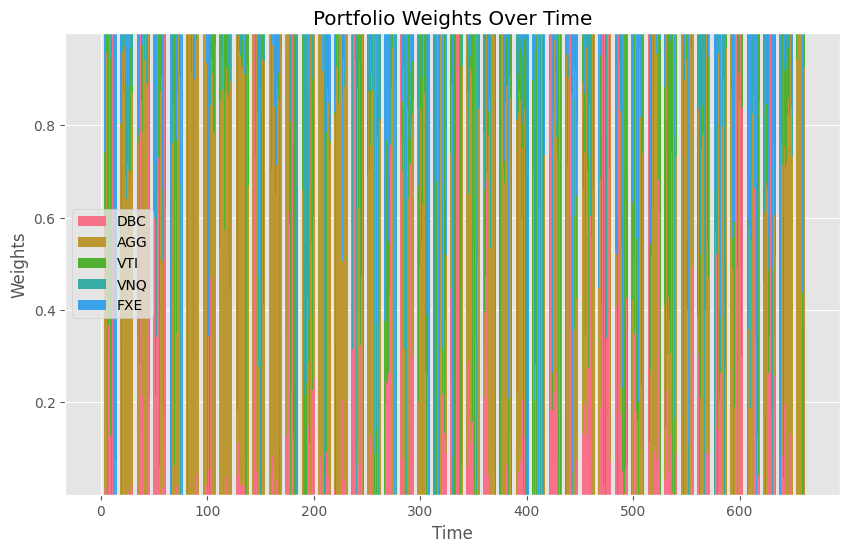

In [25]:
train_weights = markowitz_weights(Y_train_scaled, train_predictions_scaled,
                                  average_return_with_history=False,
                                  risk_free_rates=risk_free_train, # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(train_weights)

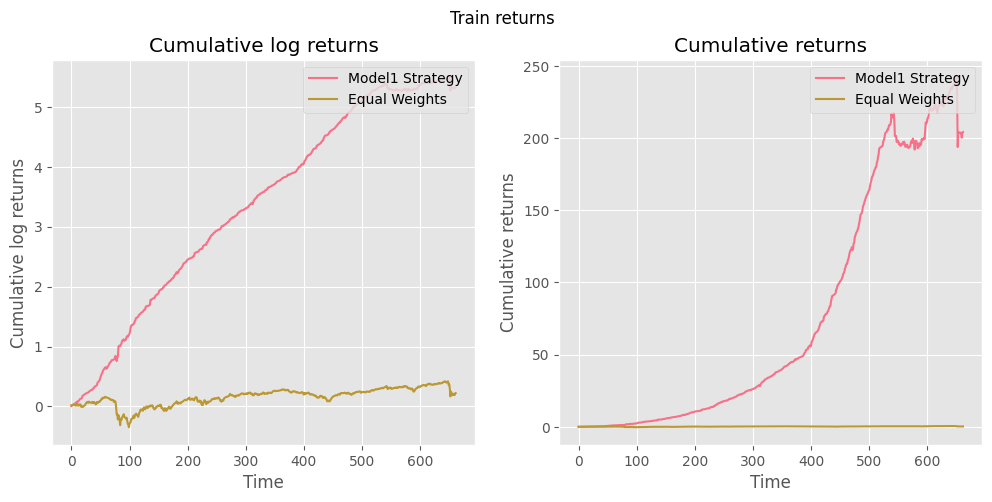

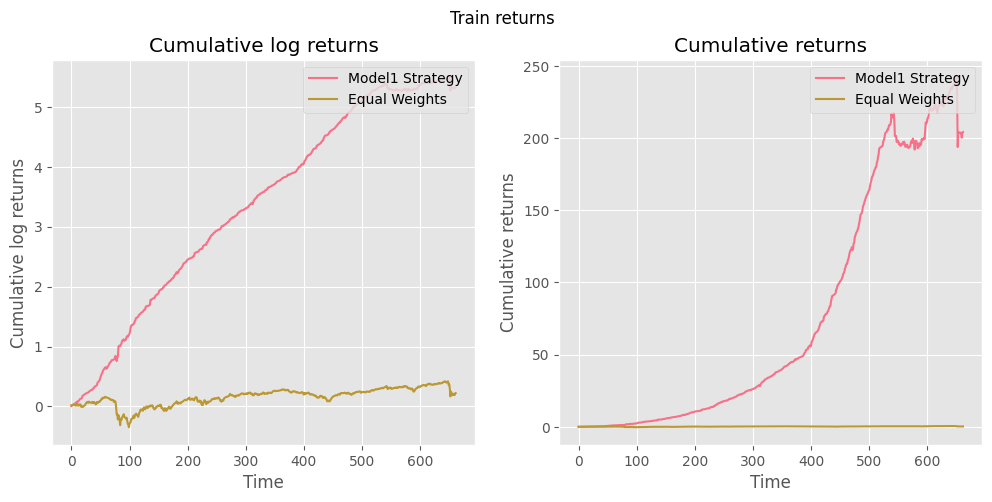

In [ ]:
calculate_and_plot_returns(Y_train_scaled, train_weights, equal_weights_train, plot_title='Train returns')

train_ret_df = calculate_and_plot_returns(Y_train_scaled, train_weights, equal_weights_train,
                                          plot_title='Train returns',
                                          time_axis=train_date_index, return_df=True)
#train_ret_df.to_csv('Model2_Train_Mod.csv')
#files.download('Model2_Train_Mod.csv')

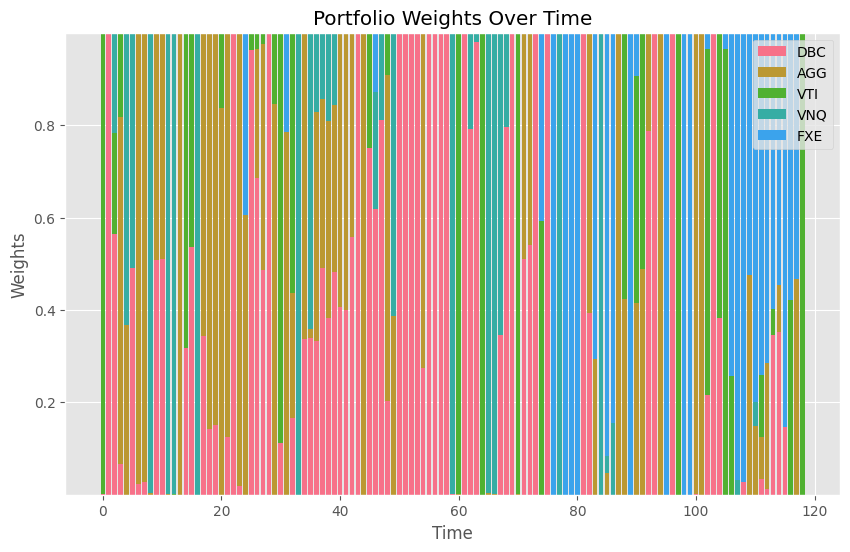

In [26]:
MARKOWITZ_TIME_WINDOW = 5
test_weights = markowitz_weights(Y_test_scaled, test_predictions_scaled,
                                 average_return_with_history=False,
                                  risk_free_rates=risk_free_test, # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(test_weights)

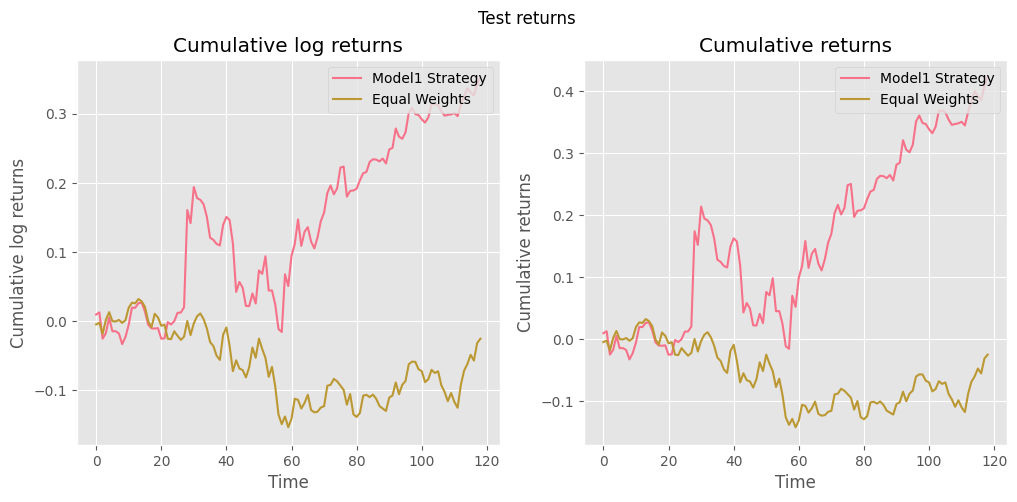

In [ ]:

test_ret_df = calculate_and_plot_returns(Y_test_scaled, test_weights, equal_weights_test,
                                          plot_title='Test returns',
                                          time_axis=test_date_index, return_df=True)
#test_ret_df.to_csv('Model2_Test_Mod.csv')
#files.download('Model2_Test_Mod.csv')

We are doing better than the naive model. However, the next step is to try and tune the model further to reduce the prediction error and increase the strategy returns.

###LIME

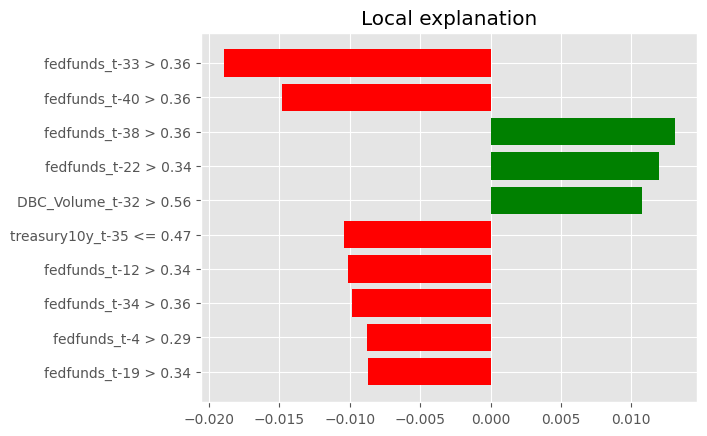

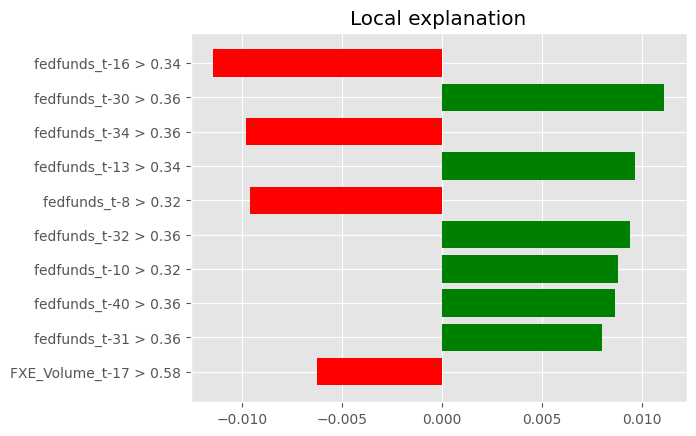

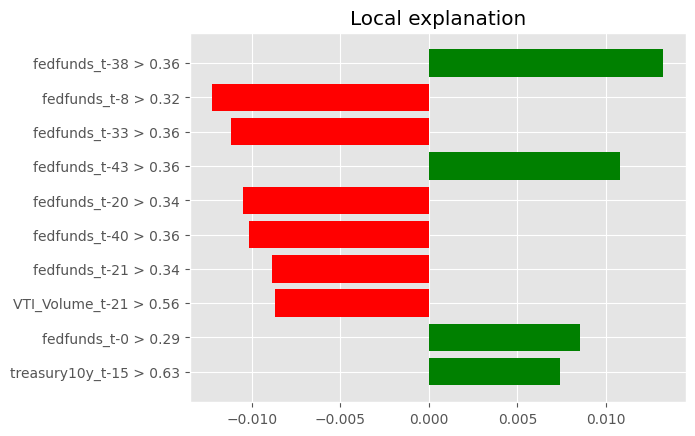

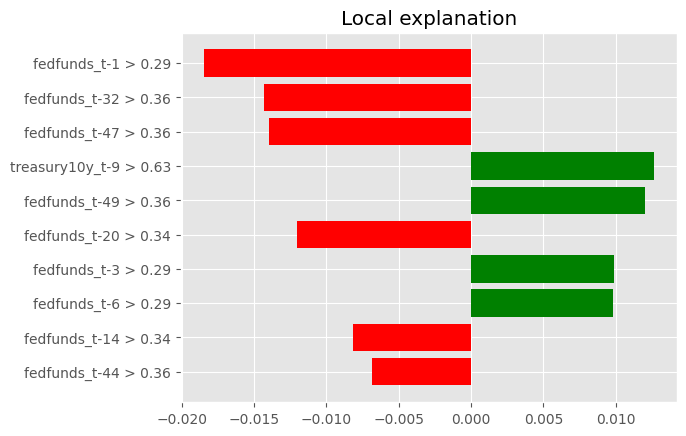

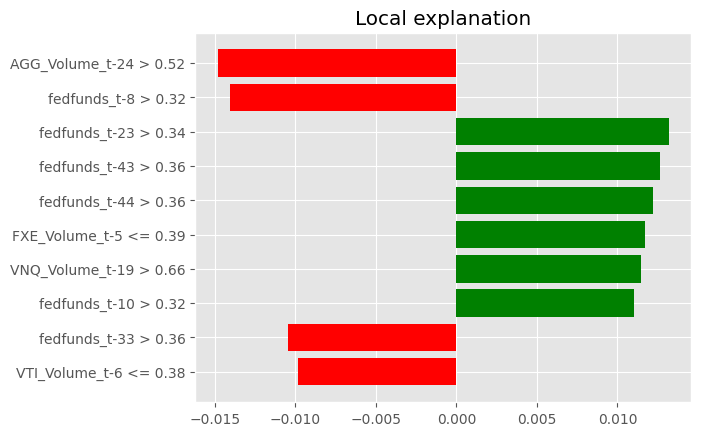

In [28]:


# this is used for probabilities, but our data is normalised, so we use this to explain
for i in range(5):
  idx = 81 # explained instance
  num_features = 5 # how many feature contained in explanation
  num_slices = 24 # split time series
  series = X_train[idx, :]
  explainer = RecurrentTabularExplainer(X_train, mode='regression', feature_names=pp.history_train_df.columns)
  exp = explainer.explain_instance(series, lambda x: model(x).numpy().reshape(-1,5)[:,i])
  exp.as_pyplot_figure()
  plt.show()

## Model Tuning
In this step, we consider:
- **Multi-head approach**: given the ETFs historically do not show high correlation across all asset classes, we will try adding more heads that will be then concatenated into one layer. The model may be then able to pick up some signals idiosyncratic to each asset class.
- **Numer of filters in each head**: Iterating over the optimal number of Conv1D filters in each head
- **Kernel size in each head**: We try varying sizes of the kernel in each head.
- **Head activation**: We test out the linear activation, elu, and relu.
-**LSTM Units**: A range of LSTM units to try.
-**L1 penalty in each head**: Prevent overfitting.
-**L2 penalty in the final Dense layer**: Prevent overfitting.

In [ ]:
"""
def build_model(hp):
  input_shape = (TIME_STEP, X_train.shape[2])
  num_heads = hp.Int("num_layers", 1, len(TICKERS))
  head_filters = hp.Int("filters_head", min_value=10, max_value=30, step=10)
  head_kernel_size = hp.Int("kernel_size_head", min_value=1, max_value=3, step=1)
  head_activation = hp.Choice("head_activation", values=['linear', 'elu', 'relu'])
  head_pool_size = hp.Int("pool_size_head", min_value=1, max_value=3, step=1)

  filters_concat = filters=hp.Int("filters_concat", min_value=10, max_value=50, step=20)
  kernel_concat = hp.Int("kernel_concat", min_value=1, max_value=10, step=2)

  lstm_units = hp.Int("units", min_value=50, max_value=150, step=50)
  # add_dropout = hp.Boolean("dropout")

  l2_dense = hp.Choice("l2_dense", [0.0, 0.001, 0.01])
  l1_head = hp.Choice("l1_head", [0.0, 0.001, 0.01])

 # adam_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  #optimizer = hp.Choice("optimizer", ["adam", "SGD"])

  model = define_model(input_shape, num_heads, head_filters, head_activation, head_kernel_size, head_pool_size,
                       filters_concat, kernel_concat, lstm_units, # adam_learning_rate, #optimizer,
                       l1_head, l2_dense
                       )
  return model


def define_model(input_shape, num_heads, head_filters, head_activation, head_kernel_size, head_pool_size,
                 filters_concat, kernel_concat, lstm_units, # adam_learning_rate, #optimizer,
                 l1_head, l2_dense
                 ):
  input_layer = keras.layers.Input(shape=input_shape)

  head_list = []
  for i in range(num_heads):
    conv_layer_head = layers.Conv1D(
      filters=head_filters,
      kernel_size=head_kernel_size,
      padding='same',
      activation=head_activation,
      kernel_regularizer=keras.regularizers.L1(l1=l1_head)
    )(input_layer)

    conv_layer_head = layers.MaxPooling1D(pool_size=head_pool_size)(conv_layer_head)
    head_list.append(conv_layer_head)

  concat_cnn = keras.layers.Concatenate(axis=1)(head_list)
  concat_cnn = layers.Conv1D(filters_concat, kernel_size=kernel_concat)(concat_cnn)
  lstm = layers.LSTM(units=lstm_units, return_sequences=True)(concat_cnn)

  lstm = layers.Dropout(0.2)(lstm)
  lstm = layers.Flatten()(lstm)
  dense = layers.Dense(5, kernel_regularizer=keras.regularizers.L2(l2=l2_dense))(lstm)

  model_multihead = keras.Model(inputs=input_layer, outputs=dense)

  model_multihead.compile(optimizer='adam', # keras.optimizers.Adam(learning_rate=adam_learning_rate), # optimizer,
                loss=keras.losses.MeanSquaredError(), metrics=['mae', 'mse'])
  return model_multihead
"""

In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    input_shape = (TIME_STEP, X_train.shape[2])

    # CNN hyperparameters
    cnn_filters_1 = hp.Int('cnn_filters_1', min_value=64, max_value=256, step=64)
    cnn_kernel_size_1 = hp.Int('cnn_kernel_size_1', min_value=2, max_value=4, step=1)
    cnn_filters_2 = hp.Int('cnn_filters_2', min_value=32, max_value=128, step=32)
    cnn_kernel_size_2 = hp.Int('cnn_kernel_size_2', min_value=2, max_value=4, step=1)
    cnn_filters_3 = hp.Int('cnn_filters_3', min_value=12, max_value=48, step=12)
    cnn_kernel_size_3 = hp.Int('cnn_kernel_size_3', min_value=2, max_value=4, step=1)
    pool_size = hp.Int('pool_size', min_value=1, max_value=3, step=1)

    # LSTM hyperparameters
    lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)

    # Model architecture
    input_layer = keras.Input(shape=input_shape)

    # CNN Branch
    cnn = layers.Conv1D(filters=cnn_filters_1, kernel_size=cnn_kernel_size_1, activation='elu', padding='same')(input_layer)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling1D(pool_size=pool_size)(cnn)

    cnn = layers.Conv1D(filters=cnn_filters_2, kernel_size=cnn_kernel_size_2, activation='elu', padding='same')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling1D(pool_size=pool_size)(cnn)

    cnn = layers.Conv1D(filters=cnn_filters_3, kernel_size=cnn_kernel_size_3, activation='elu', padding='same')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling1D(pool_size=pool_size)(cnn)

    cnn = layers.Flatten()(cnn)

    # LSTM Branch
    lstm = layers.Bidirectional(layers.LSTM(lstm_units_1, return_sequences=True))(input_layer)
    lstm = layers.Dropout(dropout_rate)(lstm)
    lstm = layers.Bidirectional(layers.LSTM(lstm_units_2, return_sequences=False))(lstm)
    lstm = layers.Dropout(dropout_rate)(lstm)

    # Concatenate CNN and LSTM outputs
    concatenated = layers.Concatenate()([cnn, lstm])


    # Reshape for BiLSTM input
    reshaped = Reshape((1, -1))(concatenated)


    lstm = Bidirectional(LSTM(128))(reshaped)



    # Output Layer
    output = layers.Dense(5)(lstm)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model


In [ ]:
#build_model(keras_tuner.HyperParameters())
build_model(keras_tuner.HyperParameters())

In [ ]:
CACHE_PATH

'./drive/MyDrive/checkpoints'

### Random Search Optimization

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="mae",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory=CACHE_PATH,
    project_name="st456_portfolio_project",
)

tuner.search(X_train, Y_train, epochs=5, validation_split=0.2)

Trial 20 Complete [00h 00m 46s]
mae: 0.05923048406839371

Best mae So Far: 0.03915448486804962
Total elapsed time: 00h 15m 12s


In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 16)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 50, 128)              4224      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 50, 128)              512       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 50, 128)              0         ['batch_normalization[0][0

In [ ]:
best_model

In [ ]:
tuner_bo

### Bayesian Optimization

In [ ]:
tuner_bo = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=1,
    overwrite=True,
    directory=CACHE_PATH,
    project_name="st456_portfolio_project",
)

tuner_bo.search(X_train, Y_train, epochs=10, validation_split=0.2)

Trial 16 Complete [00h 00m 27s]
val_loss: 0.05677139759063721

Best val_loss So Far: 0.008789243176579475
Total elapsed time: 00h 07m 30s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
192               |64                |cnn_filters_1
2                 |3                 |cnn_kernel_size_1
128               |32                |cnn_filters_2
3                 |4                 |cnn_kernel_size_2
36                |24                |cnn_filters_3
2                 |3                 |cnn_kernel_size_3
1                 |1                 |pool_size
128               |96                |lstm_units_1
48                |16                |lstm_units_2
0                 |0                 |dropout_rate

Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 0.0866 - mae: 0.2174

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-4ad800b35c69>", line 11, in <cell line: 11>
    tuner_bo.search(X_train, Y_train, epochs=10, validation_split=0.2)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search
    self._try_run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value

TypeError: object of type 'NoneType' has no len()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Get the top 2 models.
models = tuner_bo.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 16)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 50, 64)               3136      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 50, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 50, 64)               0         ['batch_normalization[0][0

### Hyperband Tuning

In [ ]:
tuner_hb = keras_tuner.Hyperband(
    hypermodel=model,
    objective="val_loss",
    overwrite=True,
    directory=CACHE_PATH,
    project_name="st456_portfolio_project_hyperbandv2_weekly",
)

callback = keras.callbacks.EarlyStopping(monitor="val_mae", patience=3, start_from_epoch=2)
tuner_hb.search(X_train, Y_train, epochs=10, validation_split=0.2, callbacks=[callback])

In [ ]:
# Get the top 2 models.
models = tuner_hb.get_best_models(num_models=5)
best_model = models[0]
best_model.summary()

best_model2 = models[1]
best_model3 = models[2]
best_model4 = models[3]
best_model5 = models[4]

keras.saving.save_model(best_model, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_v3', overwrite=True)
keras.saving.save_model(best_model2, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_2ndbest_v3', overwrite=True)
keras.saving.save_model(best_model3, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_3rdbest_v3', overwrite=True)
keras.saving.save_model(best_model4, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_4thbest_v3', overwrite=True)
keras.saving.save_model(best_model5, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_5thbest_v3', overwrite=True)

In [ ]:
#best_model = keras.saving.load_model(CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_2ndbest_v2')
best_model = keras.saving.load_model(CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_v3')
best_model.summary()

In [ ]:
best_hps = tuner_hb.get_best_hyperparameters(num_trials=5)
for i in range(0,5):
  print(best_hps[i].values)

In [ ]:
# callback = keras.callbacks.EarlyStopping(monitor="val_mae", patience=5, start_from_epoch=20)
train_fitted = best_model.fit(x=X_train, y=Y_train, epochs=100, validation_split=0.2) # callbacks=[callback],

Epoch 1/100
17/17 [==============================] - 16s 169ms/step - loss: 0.0044 - mae: 0.0513 - val_loss: 0.0099 - val_mae: 0.0777
Epoch 2/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0024 - mae: 0.0385 - val_loss: 0.0110 - val_mae: 0.0829
Epoch 3/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0014 - mae: 0.0291 - val_loss: 0.0105 - val_mae: 0.0805
Epoch 4/100
17/17 [==============================] - 1s 35ms/step - loss: 8.8550e-04 - mae: 0.0233 - val_loss: 0.0108 - val_mae: 0.0815
Epoch 5/100
17/17 [==============================] - 1s 39ms/step - loss: 5.4276e-04 - mae: 0.0181 - val_loss: 0.0116 - val_mae: 0.0852
Epoch 6/100
17/17 [==============================] - 0s 27ms/step - loss: 3.8752e-04 - mae: 0.0152 - val_loss: 0.0116 - val_mae: 0.0856
Epoch 7/100
17/17 [==============================] - 0s 24ms/step - loss: 2.3920e-04 - mae: 0.0120 - val_loss: 0.0112 - val_mae: 0.0831
Epoch 8/100
17/17 [==============================] - 0s 24

In [ ]:
# best so far
keras.saving.save_model(best_model, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_v3_retrained', overwrite=True)

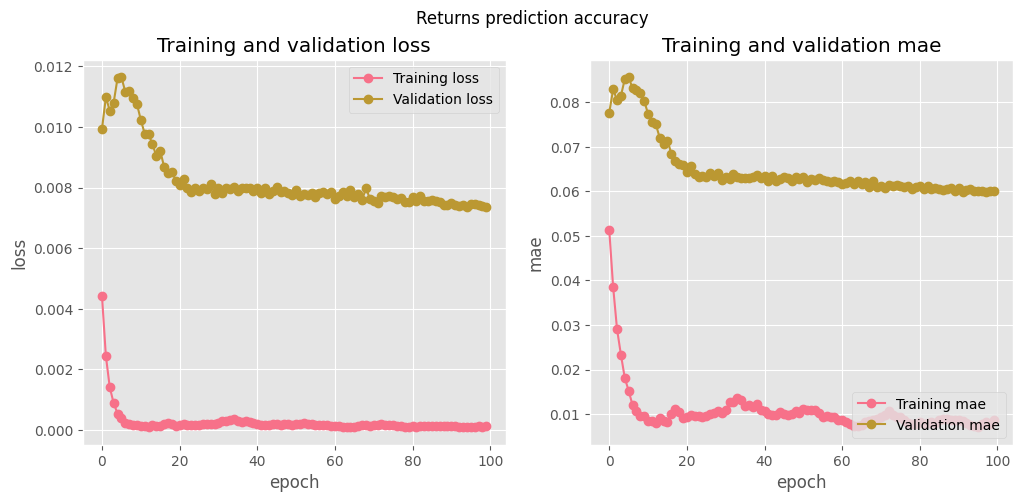

In [ ]:
plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy')

In [ ]:
# Evaluation of the model on test data
scores = best_model.evaluate(X_test, Y_test, verbose=0)
scores
print(f"Test loss: {scores[0]}" )

# Train predictions
train_predictions_bestmodel = best_model.predict(X_train)

train_predictions_bestmodel_scaled = y_scaler_train.inverse_transform(train_predictions_bestmodel)
Y_train_scaled = y_scaler_train.inverse_transform(Y_train)

# Test Predictions
test_predictions_bestmodel = best_model.predict(X_test)

test_predictions_bestmodel_scaled = y_scaler_test.inverse_transform(test_predictions_bestmodel)
Y_test_scaled = y_scaler_test.inverse_transform(Y_test)

Test loss: 0.07327938824892044
4/4 [==============================] - 0s 11ms/step


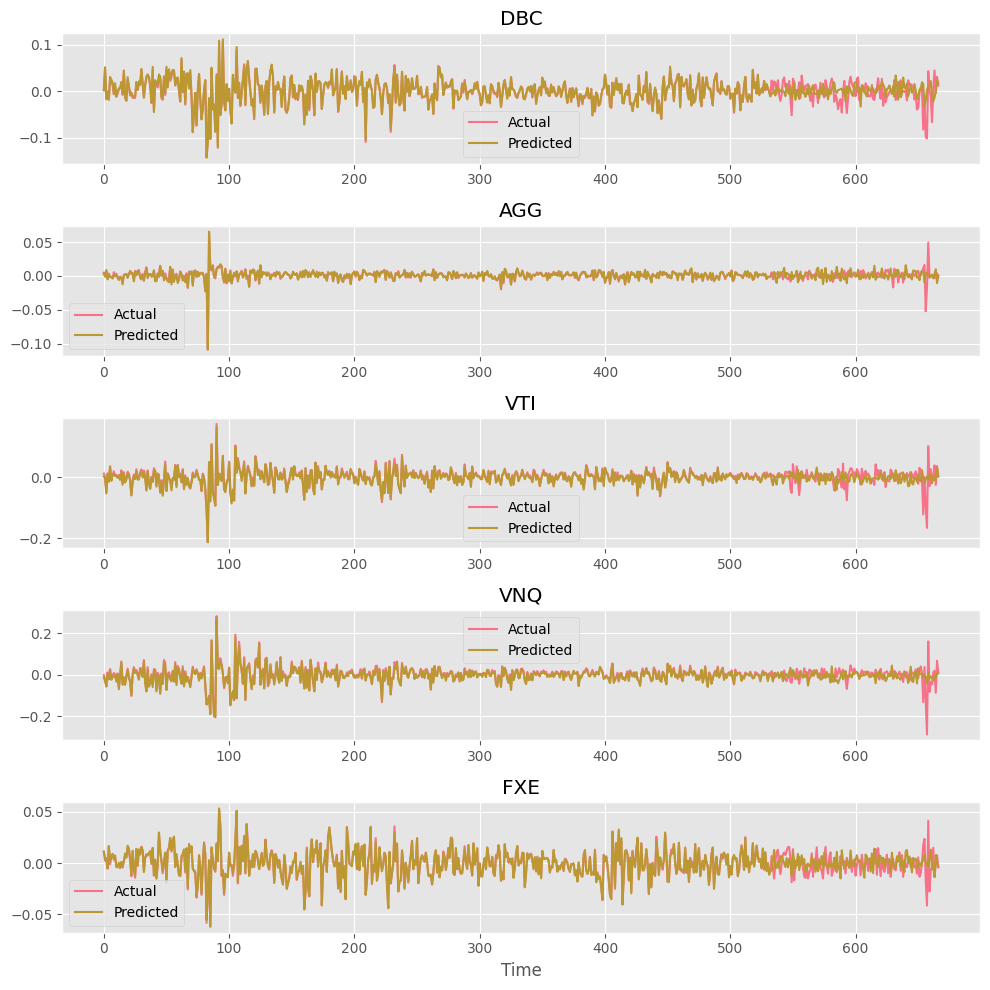

In [ ]:
plot_returns(Y_train_scaled, train_predictions_bestmodel_scaled)

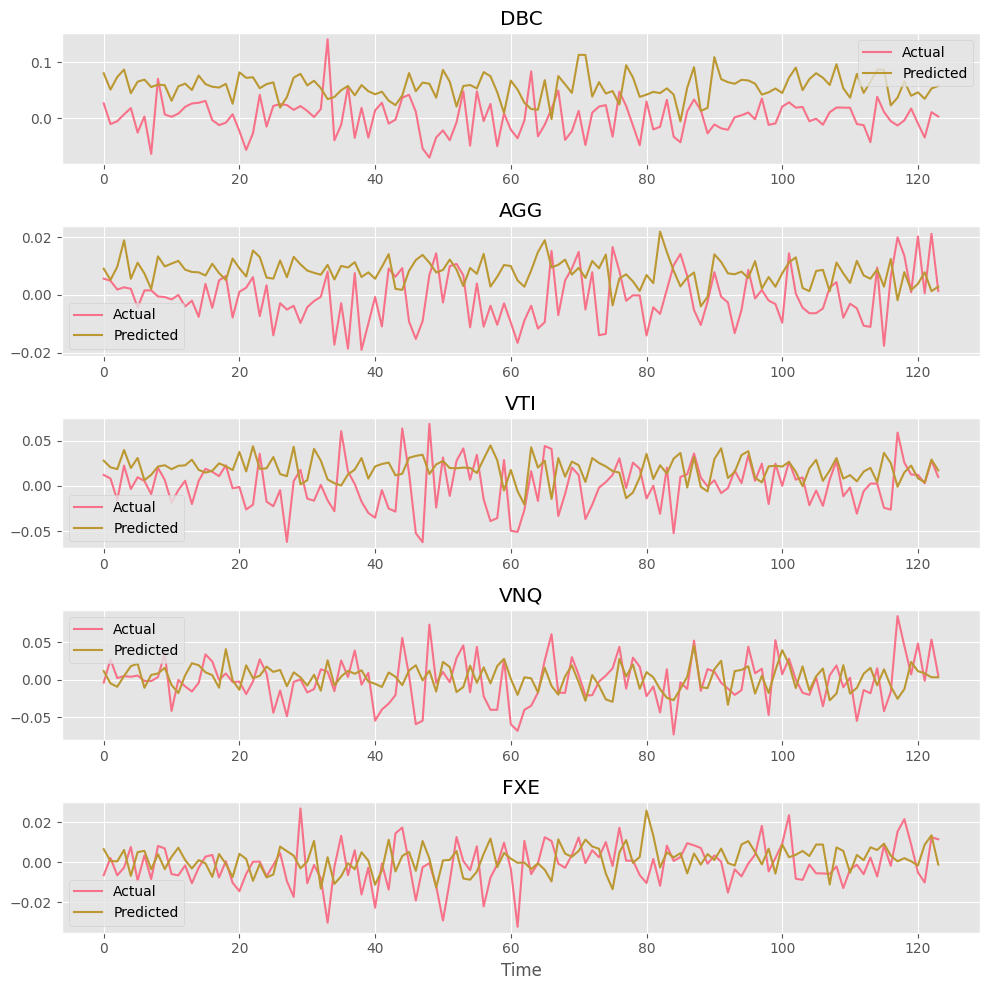

In [ ]:
plot_returns(Y_test_scaled, test_predictions_bestmodel_scaled)

### Model 1

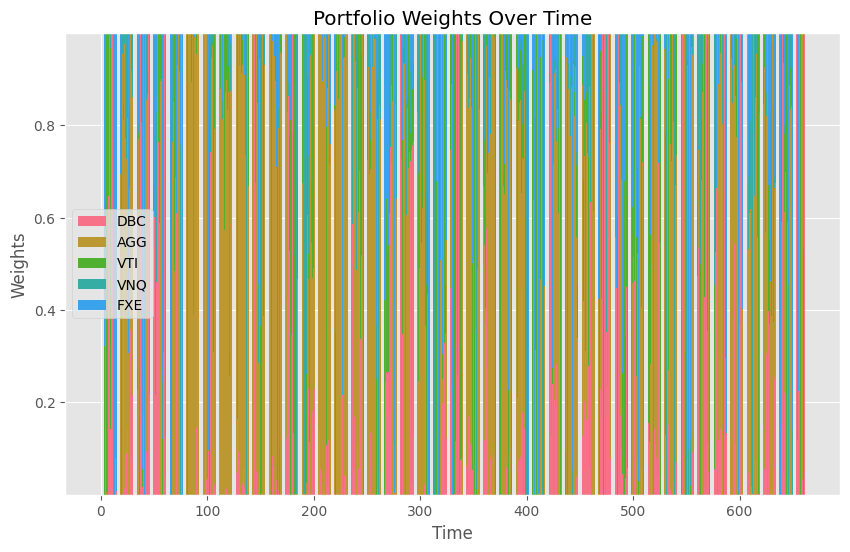

In [ ]:
MARKOWITZ_TIME_WINDOW = 5
train_weights = markowitz_weights(Y_train_scaled, train_predictions_bestmodel_scaled,
                                 average_return_with_history=False,
                                  risk_free_rates=risk_free_train, # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  ) #train_predictions_bestmodel_scaled
plot_portfolio_weights(train_weights)

In [ ]:
best_model

NameError: name 'best_model' is not defined

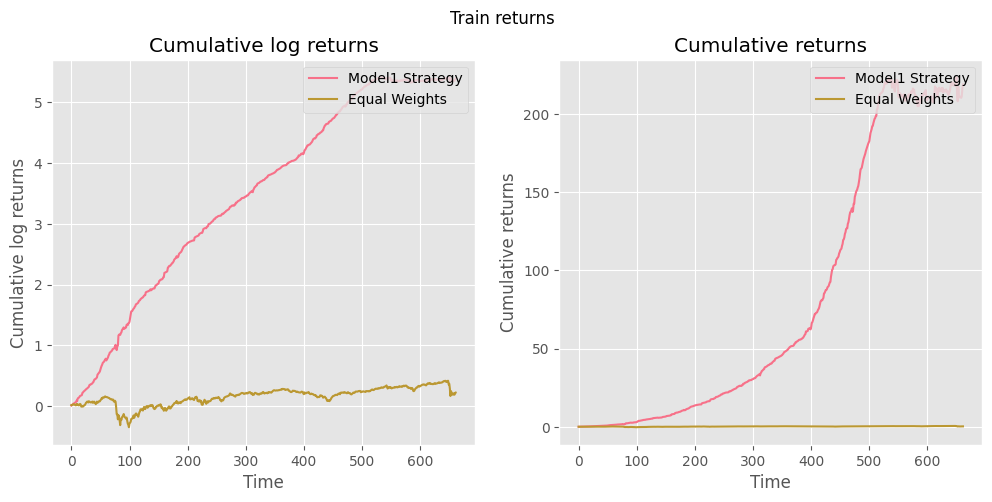

In [ ]:
calculate_and_plot_returns(Y_train_scaled, train_weights, equal_weights_train, plot_title='Train returns')

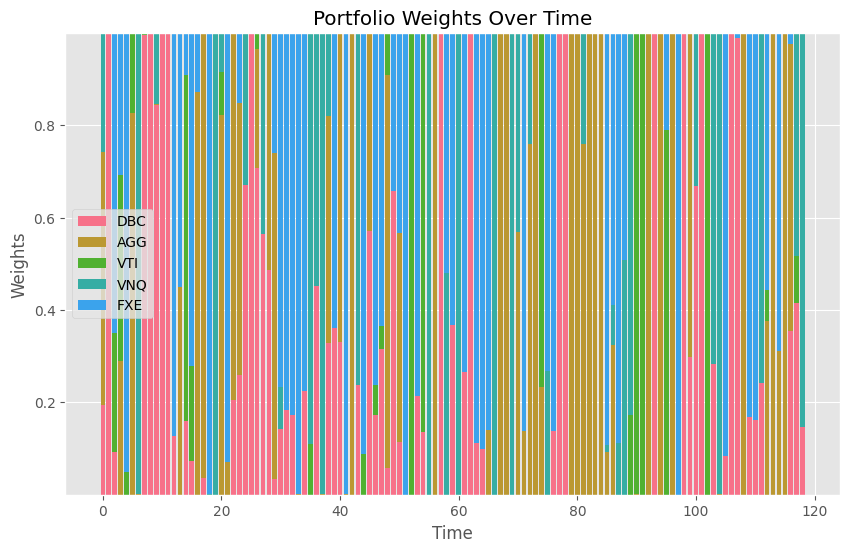

In [ ]:
# Test
test_weights = markowitz_weights(Y_test_scaled, train_predictions_bestmodel_scaled,
                                 average_return_with_history=False,
                                  risk_free_rates=risk_free_test, # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(test_weights)

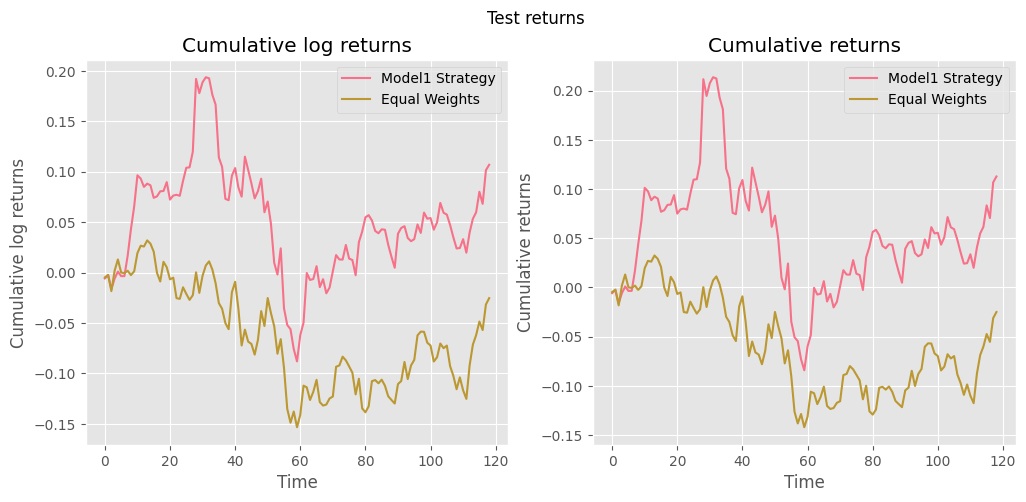

In [ ]:
calculate_and_plot_returns(Y_test_scaled, test_weights, equal_weights_test, plot_title='Test returns')